Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [ ]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer

In [ ]:
import numpy as np

# This will create a wrangle function for our data

def wrangle(X):
  X = X.copy()

  # This will convert 'date_recorded' to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  # This will extract the components from 'date_recorded', then drop the now redundant
  # original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  # This will clean small latitude values
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  # This will engineer a new feature: Water used per person 'water_per_person'
  X['water_per_person'] = X['amount_tsh'].replace({0:1})/X['population'].replace({0:1})
  # This will engineer a new feature: Age of pump 'years_old' and clean the
  # 'construction_year' column
  X['years_old'] = X['year_recorded']-X['construction_year'].replace({0:1990})
  # This will engineer a new feature: average population served per year
  # 'served_per_year'
  X['served_per_year'] = X['population'].replace({0:1})/X['years_old'].replace({0:1})
  # This will replace remaining zeros with nulls, so that we can impute them later on
  # This will also establish a "missing" indicator, which may be used for predictive
  # purposes later on as well
  cols_with_zeros = ['longitude', 'latitude', 'gps_height']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  # This will wash out duplicate or redundant columns
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)
  # This will drop values that remain static or always vary, neither of which is
  # useful for predictive purposes
  unusable_variance = ['recorded_by']
  X = X.drop(columns=unusable_variance)
  # This will set index to 'id'
  X.set_index(X['id'], inplace=True)

  # This will return the modified dataframe
  return X

In [ ]:
df=wrangle(train)
test=wrangle(test)

In [ ]:
X_train = df.drop(['status_group'], axis=1)
y_train = pd.DataFrame(df['status_group'])

In [ ]:
# Let's create a cardinality check function

def cardinality_check (n, df):
  features = []
  cardinality_score = []

  for _ in range(len(df.columns)):
    if len(df[df.columns[_]].value_counts()) > n:
      features.append(df.columns[_])
      cardinality_score.append(len(df[df.columns[_]].value_counts()))

  feature_list = dict(zip(features, cardinality_score))

  return feature_list

In [ ]:
# This will call our function and allow us find a high cardinality cutoff point
high_cardinality = cardinality_check(150, X_train)
# This will repeat the process for our test data
high_cardinality_test = cardinality_check(150, test)

In [ ]:
# This will create a dataframe, using the results of our function, of LOW cardinality features
lc_X_train = X_train.drop(columns= list(high_cardinality.keys()))
# This will repeat the process for our test data
lc_X_test = test.drop(columns= list(high_cardinality_test.keys()))

In [ ]:
# This will create a dataframe of HIGH cardinality features
hc_X_train = X_train[list(high_cardinality.keys())]
# This will repeat the process for our test data
hc_X_test = test[list(high_cardinality.keys())]

In [ ]:
one_hot = ce.OneHotEncoder(use_cat_names=True)
one_hot.fit(lc_X_train, y_train['status_group'])
lc_X_train = one_hot.transform(lc_X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
lc_X_test = one_hot.transform(lc_X_test)

In [ ]:
ordinal = ce.OrdinalEncoder()
ordinal.fit(hc_X_train, y_train['status_group'])
hc_X_train = ordinal.transform(hc_X_train)

In [ ]:
hc_X_test = ordinal.transform(hc_X_test)

In [ ]:
X_train2 = lc_X_train.merge(hc_X_train, on=lc_X_train.index)

In [ ]:
X_test2 = lc_X_test.merge(hc_X_test, on=lc_X_test.index)

In [ ]:
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
impute.fit(X_train2, y_train['status_group'])
X_test2 = impute.transform(X_test2)

In [ ]:
print('Baseline Accuracy is:', df['status_group'].value_counts(normalize=True).max())

Baseline Accuracy is: 0.543080808080808


In [ ]:
rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier()
)

In [ ]:
rf_cvs = cross_val_score(rf, X_train2, y_train, cv=5, n_jobs=-1)

In [ ]:
print(rf_cvs)
print(rf_cvs.mean())
print(rf_cvs.std())

[0.81363636 0.80715488 0.81599327 0.81069024 0.80656566]
0.8108080808080809
0.0036398692417630787


In [ ]:
parasect = {'randomforestclassifier__n_estimators': np.arange(20, 61, 20),
         'randomforestclassifier__max_depth': np.arange(10, 31, 10),
         'randomforestclassifier__max_samples': np.arange(0.3, 0.71, 0.2)}

In [ ]:
rf_gs = GridSearchCV(rf, parasect, cv=5, n_jobs=-1, verbose=1)

In [ ]:
rf_gs.fit(X_train2, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 12.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                     

In [ ]:
rf_gs.best_estimator_

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=None, max_samples=0.7,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=None,
                                        oob_score=False

In [ ]:
rf_gs.best_score_

0.8112962962962964

In [ ]:
y_pred = rf_gs.predict(X_test2)

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix

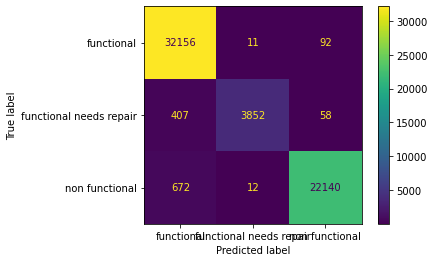

In [ ]:
plot_confusion_matrix(rf_gs, X_train2, y_train, values_format='.0f');

In [ ]:
accuracy = (32156+3852+22140)/(32156+11+92+407+3852+58+672+12+22140)
accuracy

0.978922558922559

In [ ]:
precision = 22140/(22140+58+92)
precision

0.9932705248990579

In [ ]:
recall = 22140/(22140+12+672)
recall

0.9700315457413249

In [ ]:
f1 = 2*(precision*recall)/(precision+recall)
f1

0.9815134991355233

In [ ]:
data = {'id': test.index, 'status_group': y_pred}
submission = pd.DataFrame(data)

In [ ]:
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [ ]:
submission.set_index('id', inplace=True)

In [ ]:
submission.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [ ]:
submission.to_csv('Submission.csv')